In [56]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
import matplotlib.colors as mpl_colors
import cartopy.crs as ccrs

### Load Data and Station List

In [57]:

data_dir = '../output/'

# Combine datasets using xarray
data = xr.open_mfdataset(f"{data_dir}/axisem3d_synthetics.nc.*", engine="netcdf4", data_vars="different", concat_dim="dim_station", combine="nested")
# Load station location information
stations = pd.read_csv("input_files/STATIONS_OUTPUT.txt", delim_whitespace=True, header=2, names=["name", "network", "x", "y", "useless", "depth"])
stations["name_network"] = stations["network"] + '.' + stations["name"].astype(str).str.zfill(4)
station_names_decoded = pd.Series(data["list_station"].values).str.decode("utf-8")
station_map = {name: idx for idx, name in enumerate(station_names_decoded)}
# Apply the permutation vector
stations["permutation"] = stations["name_network"].map(station_map)

In [58]:
# define coordinate transform for station locations
lat_pole = 37.7
lon_pole = -122.1
x_utm, y_utm = ccrs.UTM(zone=10).transform_point(lon_pole, lat_pole, src_crs=ccrs.Geodetic())

stations["x_utm"] = stations["x"] + x_utm
stations["y_utm"] = stations["y"] + y_utm
stations

,name,network,x,y,useless,depth,name_network,permutation,x_utm,y_utm
0,0,FAKE,0.0,-55000.0,0.0,0.0,FAKE.0000,3937,579339.236098,4.117911e+06
1,1,FAKE,-10000.0,-54000.0,0.0,0.0,FAKE.0001,4897,569339.236098,4.118911e+06
2,2,FAKE,-9000.0,-54000.0,0.0,0.0,FAKE.0002,4898,570339.236098,4.118911e+06
3,3,FAKE,-8000.0,-54000.0,0.0,0.0,FAKE.0003,4899,571339.236098,4.118911e+06
4,4,FAKE,-7000.0,-54000.0,0.0,0.0,FAKE.0004,4900,572339.236098,4.118911e+06
...,...,...,...,...,...,...,...,...,...,...
9472,9472,FAKE,7000.0,54000.0,0.0,0.0,FAKE.9472,5053,586339.236098,4.226911e+06
9473,9473,FAKE,8000.0,54000.0,0.0,0.0,FAKE.9473,5054,587339.236098,4.226911e+06
9474,9474,FAKE,9000.0,54000.0,0.0,0.0,FAKE.9474,5055,588339.236098,4.226911e+06
9475,9475,FAKE,10000.0,54000.0,0.0,0.0,FAKE.9475,5056,589339.236098,4.226911e+06


In [65]:
x= stations['x']
y= stations['y']

In [59]:
lat_hypo = 37.77
lon_hypo = -122.13
x_utm_hypo, y_utm_hypo = ccrs.UTM(zone=10).transform_point(lon_pole, lat_pole, src_crs=ccrs.Geodetic())

df = pd.read_csv('input_files/cert20.csv')
South_df = df[df['Y'] < 37.85] # choose the southern part only

lons = South_df['X'][:]
lats = South_df['Y'][:]

src_crs = ccrs.Geodetic()
target_crs = ccrs.UTM(zone=10)

# Transform the points
transformed_points = target_crs.transform_points(src_crs, lons, lats)

# Extract x and y coordinates from the transformed points
x_trace = transformed_points[:, 0]
y_trace = transformed_points[:, 1]

x_dense = np.linspace(min(x_trace), max(x_trace), 1000)

# Perform linear regression on the original x_trace and y_trace
slope, intercept = np.polyfit(x_trace, y_trace, 1)  # Fit a linear model (y = mx + c)

# Predict y values based on the linear regression using the denser x-axis points
y_pred_dense = slope * x_dense + intercept


### Process Data for Plotting

In [60]:
# put everything into simple numpy arrays for plotting, including sorting the wave data
x_coords = stations["x_utm"].values
y_coords = stations["y_utm"].values
time = data["data_time"].values

disp_data = data["data_wave"].values[stations["permutation"],:,:]#convert from nm to m
# compute velocity and acceleration

dt = time[1] - time[0]
vel_data = np.gradient(disp_data, dt, axis=2)
acc_data = np.gradient(vel_data, dt, axis=2)

# compute PGD, PGV, and PGA
PGD = np.amax(abs(disp_data), axis=2)
PGV = np.amax(abs(vel_data),  axis=2)
PGA = np.amax(abs(acc_data),  axis=2)

### Plot Intensity Maps

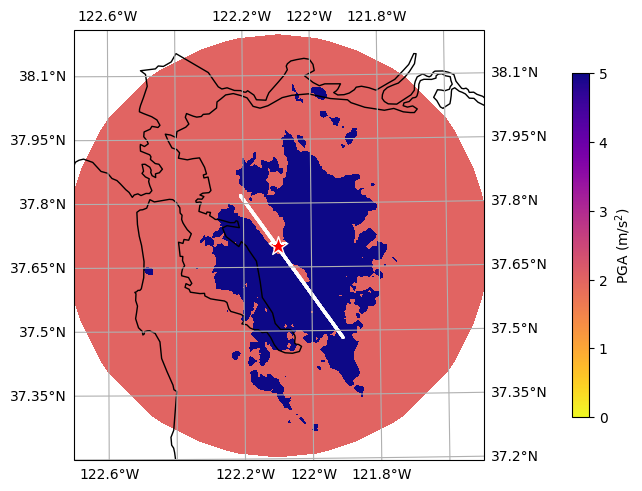

In [61]:
#fig, axes = plt.subplots(constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
fig, axes = plt.subplots(constrained_layout = True, subplot_kw={'projection': ccrs.UTM(zone=10, southern_hemisphere= False)})
axes.set_extent((lon_pole - 0.6, lon_pole + .6 , lat_pole - .5 , lat_pole + .5), crs=ccrs.Geodetic())
axes.coastlines(resolution="10m")

pgv_norm = mpl.colors.Normalize(vmin=0, vmax=5)

axes.tricontourf(x_coords,y_coords, PGA[:,1], cmap='plasma_r',norm=pgv_norm)

axes.scatter(x_dense, y_pred_dense,s= 1, facecolor = 'w')
axes.scatter(x_utm_hypo, y_utm_hypo, marker = '*', s= 200, facecolor = 'r', edgecolor = 'w')

#circle = plt.Circle((x_utm, y_utm), radius=60000, facecolor='none', edgecolor = 'black')
#axes.add_patch(circle)
axes.gridlines(draw_labels=True)

fig.colorbar(mpl.cm.ScalarMappable(norm=pgv_norm, cmap='plasma_r'), ax=axes, shrink=0.8, label="PGA ($\mathrm{m/s}^2$)")

#plt.savefig('PGA_N.png', dpi=300, bbox_inches='tight')

### Make Animation / Figure

/tmp/ipykernel_267068/4225862447.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  frames.append(tcf00.collections + [timelabel])


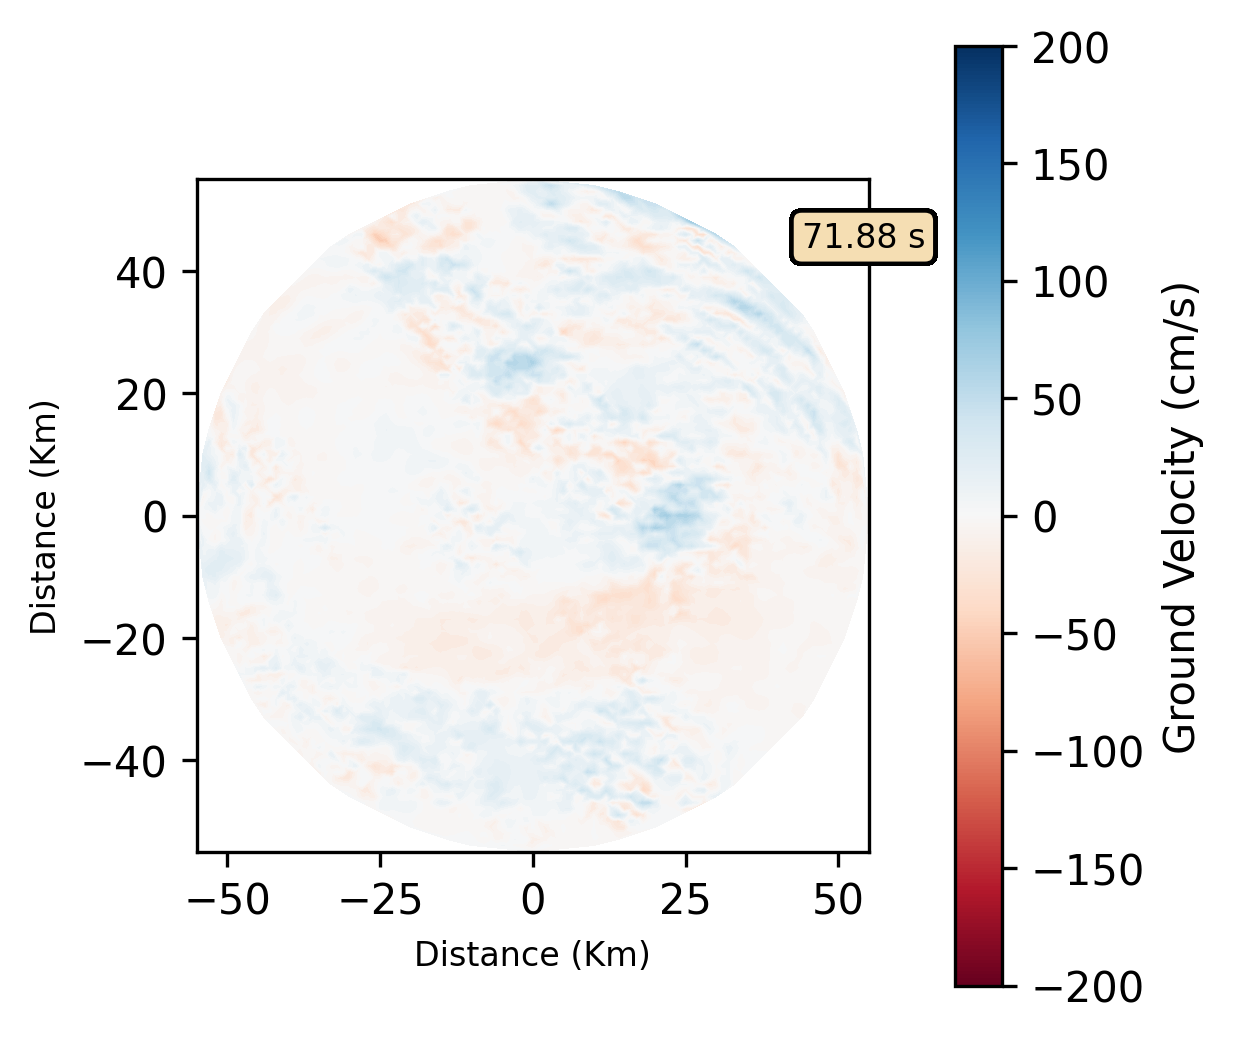

In [67]:
from matplotlib import animation

fig, axes = plt.subplots(1, 1, figsize=(4, 4),dpi=300, constrained_layout = True)

i = 100

#axes.set_title("Velocity with Time ", fontsize=2)
axes.set_xlabel('Distance (Km)', fontsize=8)
axes.set_ylabel('Distance (Km)', fontsize=8)
axes.set_aspect('equal')

# create fixed color bars using linear Normalize and dummy ScalarMapables
pgv_norm = mpl.colors.Normalize(vmin=-200, vmax=200)
fig.colorbar(mpl.cm.ScalarMappable(norm=pgv_norm, cmap='RdBu'), ax= axes, shrink=0.8, label="Ground Velocity (cm/s)")

# Use ArtistAnimation - flexible, but it is memory hungry as you have to make every plot element for every frame first
frames = []
props = dict(boxstyle='round', facecolor='wheat')
for i in range(len(time)-50):
    timelabel = axes.text(0.9,0.9, f"{time[i+10]:.2f} s", ha="left", transform=axes.transAxes, bbox=props, fontsize = 8)
    # tricontourf lets us use an unstructured set of points for contouring, and doesn't look too bad when we have a lot of stations
    tcf00 = axes.tricontourf(x/1e3, y/1e3, vel_data[:,1,i+10], levels=25, cmap="RdBu", norm=pgv_norm)
    # collect each frame and append to frame list
    frames.append(tcf00.collections + [timelabel])
    
    
anim = animation.ArtistAnimation(fig, frames)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)

plt.show()

anim.save('SF.mp4', writer=writer)
